<a href="https://colab.research.google.com/github/moodychinsaki/AMDproject/blob/main/amdPRandDGpart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
!pip install pyspark py4j
!pip install findspark
os.environ['KAGGLE_USERNAME'] = "besimsakaoglu"
os.environ['KAGGLE_KEY'] = "eff3f17c8e73c3303a2ffb896e2d09be"
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=6d595cc9410e9b2245aec975f4780fe4fc94778b3184e7a78efbf0a44e91bad8
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
100% 21.0G/21.0G [03:09<00:00, 157MB/s]
100% 21.0G/21.0G [03:09<00:00, 119MB/s]


In [ ]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext, SparkConf
import networkx as nx
#spark = SparkSession.builder.master("local[*]").getOrCreate() which tells Spark to run locally on your computer using all the available cores.
# if collab is not available
from pyspark.sql.functions import col, array_contains
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql import functions as f
import itertools
import math
import csv
from google.colab import files
from pyspark.sql.functions import desc
from pyspark.sql.functions import col

In [ ]:
import zipfile
import tempfile
import shutil
from pyspark.sql import SparkSession

# building a Spark session
spark = SparkSession.builder.appName("AmazonReviews").getOrCreate()

zip_file = zipfile.ZipFile('/content/amazon-us-customer-reviews-dataset.zip')
review_file = "amazon_reviews_us_Automotive_v1_00.tsv"
temp_dir = tempfile.mkdtemp()
zip_file.extract(review_file, path=temp_dir)
extracted_file_path = f"{temp_dir}/{review_file}"

local_file_path = "/tmp/amazon_reviews_us_Automotive_v1_00.tsv"
shutil.move(extracted_file_path, local_file_path)

# Read the TSV file into a DataFrame and limit the number of rows to 10000 we can extend to all data but for now ineffecient for storage and time limitation
df = spark.read.option("delimiter", "\t").option("header", "true").option("inferSchema", "true").csv(local_file_path)#.limit(10000) #10000 geri eski haline getir

# Select specific columns from the DataFrame
selected_df = df.select("customer_id" , 'review_id',"product_id",'product_title')

Product **linkage**

In [ ]:
crRDD = selected_df.rdd.map(lambda x: (x[0], x[2]))\
                         .groupByKey().map(lambda x : (x[0], list(x[1])))\
                         .filter(lambda x: len(x[1])>=2)

 #The purpose is to filter out customers who have reviewed fewer than 2 products, as they would not contribute to the link analysis.

In [ ]:



# function to generate combinations of product pairs for each customer
def my_combination(row):
    prodID = row[1]
    res1 = [(product_id, customer_id) for product_id, customer_id in itertools.permutations(prodID, 2)]
    return (res1)


# creating link between products reviewed by the same customer-shared customer as an edge between those products
edges = crRDD.flatMap(lambda x: my_combination(x))

# Calculate the out-degree for each product
out_degrees = edges.countByKey()

# introduce the PR parameters to the environment - hyperparameters bu parametreleri degistirmek convergence degistirir hizlanir ya da yavaslar PR degeri artar ya da azalir
alpha = 0.85 # Google optimal one
iterations = 50  # Maximum number of iterations
threshold =  0.001  # Adjust the convergence threshold


#  list of unique products
products = crRDD.flatMap(lambda x: x[1]).distinct().collect()

#  dictionary in order to mapping product IDs to indices
product_indices = {product: idx for idx, product in enumerate(products)}

#  total number of nodes (products)
total_nodes = len(products)

# initializing transition matrix (probability matrix)
transition_matrix = edges.map(lambda x: (product_indices[x[0]], product_indices[x[1]], 1/out_degrees[x[0]]))

# the Google matrix (GM)
p = 1 / total_nodes
GM = transition_matrix.map(lambda x: (x[1], x[0], alpha * x[2] + (1 - alpha) * p))

# Initialize the PageRank vector
pagerank_vector = np.full(total_nodes, 1 / total_nodes)

# Perform PageRank iterations
for iteration in range(iterations):
    prev_pagerank_vector = pagerank_vector.copy()
    pagerank_vector = GM.map(lambda x: (x[0], x[2] * pagerank_vector[x[1]])).reduceByKey(lambda x, y: x + y).sortByKey()
    pagerank_vector = np.array(pagerank_vector.map(lambda x: x[1]).collect())
    print(f"Number of iterations: {iteration + 1}")
#  number of iterations
#print(f"Number of iterations: {iteration + 1}")
        # calculating the change in PageRank scores and display
    change = np.sum(np.abs(prev_pagerank_vector - pagerank_vector))

    print(f"Number of iterations: {iteration + 1}, Change: {change}")

    # checkin for convergence if it converged or not
    if change < threshold:
        print("Converged!")
        break
# storing final PageRank scores
pagerank_scores = [(product, pagerank) for product, pagerank in zip(products, pagerank_vector)]

# sorting them in descending order
sorted_pagerank_scores = sorted(pagerank_scores, key=lambda x: x[1], reverse=True)

#  top 25 PageRank scores - most popular car products
print("Top 25 PageRank Scores:")
for i, (product, score) in enumerate(sorted_pagerank_scores[:25], start=1):
    print(f"Rank {i}: Product ID: {product}, PageRank Score: {score}")


# Stop the Spark session
#spark.stop()

Number of iterations: 1
Number of iterations: 1, Change: 0.8847127571836604
Number of iterations: 2
Number of iterations: 2, Change: 0.25290946545172976
Number of iterations: 3
Number of iterations: 3, Change: 0.11740031646951773
Number of iterations: 4
Number of iterations: 4, Change: 0.09379803006029742
Number of iterations: 5
Number of iterations: 5, Change: 0.07905980491046048
Number of iterations: 6
Number of iterations: 6, Change: 0.06710359356807785
Number of iterations: 7
Number of iterations: 7, Change: 0.057009597519552875
Number of iterations: 8
Number of iterations: 8, Change: 0.04844197155344943
Number of iterations: 9
Number of iterations: 9, Change: 0.04117184778955571
Number of iterations: 10
Number of iterations: 10, Change: 0.034994149303474664
Number of iterations: 11
Number of iterations: 11, Change: 0.02974591115596764
Number of iterations: 12
Number of iterations: 12, Change: 0.02528516297712182
Number of iterations: 13
Number of iterations: 13, Change: 0.02149410

In [ ]:
print(total_nodes)
print("Number of edges:", edges.count())

572151
Number of edges: 15782304


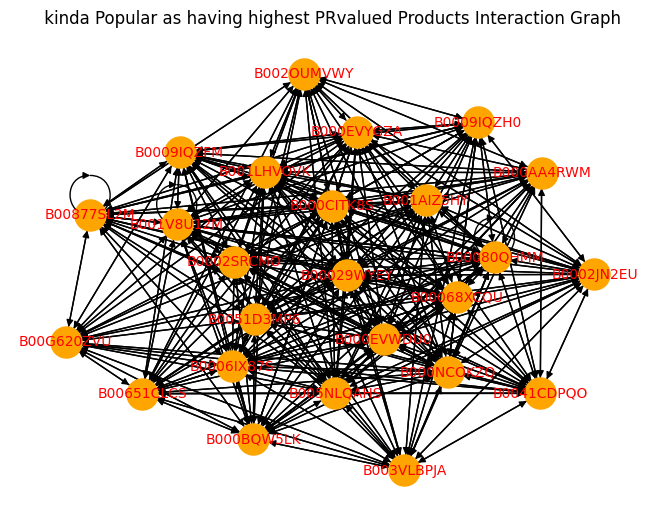

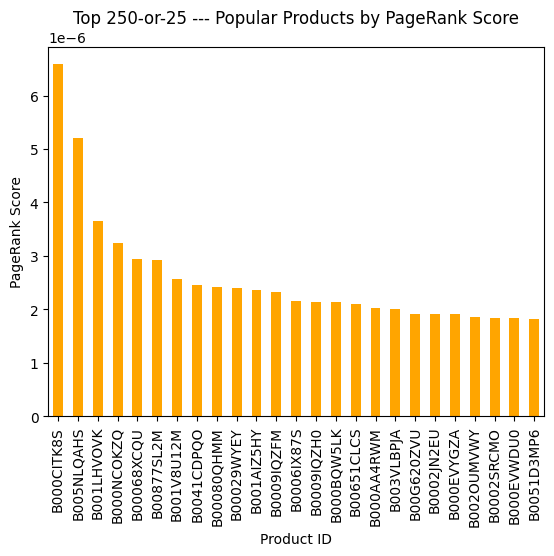

In [ ]:
# directed graph creation
G = nx.DiGraph()
edge_list = edges.collect()
for edge in edge_list:
    G.add_edge(edge[0], edge[1])

# sorting products by their PR score
sorted_products = sorted(pagerank_scores, key=lambda x: x[1], reverse=True)

# introducing top 250 or 25 products
top_250_products = sorted_products[:25]
#check with 25 to observe directed graph slightly isolated and localized ones especially localized one has highest PR and many incoming links

# subgraph for the top 250 products
top_250_product_ids = [product for product, _ in top_250_products]
top_250_graph = G.subgraph(top_250_product_ids)

# depiction of the subgraph
pos = nx.spring_layout(top_250_graph)
nx.draw(top_250_graph, pos, with_labels=True, node_size=500, node_color='orange', font_size=10, font_color='red')
plt.title(" kinda Popular as having highest PRvalued Products Interaction Graph")
plt.show()

# pandas dataframe created for the top 250 products and their PageRank scores visualization
top_250_products_with_pagerank = [(product, pagerank) for product, pagerank in top_250_products]
df = pd.DataFrame(top_250_products_with_pagerank, columns=['Product', 'PageRank'])

# PR scores as bar plot
df.plot.bar(x='Product', y='PageRank', color='orange', legend=False)
plt.title("Top 250-or-25 --- Popular Products by PageRank Score")
plt.xlabel("Product ID")
plt.ylabel("PageRank Score")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Stop the Spark session
#spark.stop()

# **improve convergence: Experimental part and I tried couple of them**

Increase Max Iterations:  may give the algorithm more time to converge.

Adjust Threshold:  adjust the convergence threshold. If the change in PageRank scores between iterations falls below this threshold, the algorithm is considered to have converged. setting a smaller threshold to make the algorithm more sensitive to changes in PR scores.

Damping Factor  (e.g., 0.85) is commonly used, adjust it to see if it affects convergence.

Check for Isolated Nodes

Parallelism: increase parallelism or distribute the computation to multiple nodes or cores to speed up convergence.

